In [1]:
import sys
from pathlib import Path

%load_ext autoreload
%autoreload 2

root_path = Path("/home/olivieri/exp").resolve()
src_path = root_path / "src"
sys.path.append(f"{str(src_path)}")

In [2]:
from IPython.display import Markdown
from concurrent.futures import ThreadPoolExecutor, as_completed # for paralellism
import time

from prompter import *
from data import *
from utils import *
from model import GoogleAIStudio

# Inference

In [22]:
# VLM
vlm = GoogleAIStudio(model="gemini-2.0-flash")

# Setting
BY_MODEL = "LRASPP_MobileNet_V3"
SPLIT_BY = "non-splitted"

promptBuilder = PromptBuilder(
    by_model            = BY_MODEL,
    alpha               = 0.8,
    image_size          = 520,
    array_size          = (32, 32),
    class_map           = CLASS_MAP, # imported from 'class_map.py'
    color_map           = COLOR_MAP_DICT,
    split_by            = SPLIT_BY
)

## Single Sample

In [36]:
promptBuilder.load_modules(
    context_module          = ContextModule(variation="default"),
    color_map_module        = Image_ColorMapModule(variation="default"),
    input_format_module     = ConcatMasks_NoSc_Hz_InputFormatModule("original"),
    task_module             = TaskModule(variation="default"),
    output_format_module    = OutputFormatModule(variation="default"),
    support_set_module      = SupportSetModule(variation="default", sup_set_idxs=()),
    query_module            = QueryModule(variation="default"),
    eval_module             = EvalModule(variation="7_incomplet+strict+precision+error_types+spatial_locs")
)

In [38]:
query_idx = 0

I am in a multi-class semantic segmentation context and I want to compare a **prediction** mask with a **ground truth** mask, both segmented over the same **scene**.


In the masks, the classes are mapped to a specific color as defined by a color map, which is shared by both masks. What follows is a mapping between class names, class identifiers and colors.


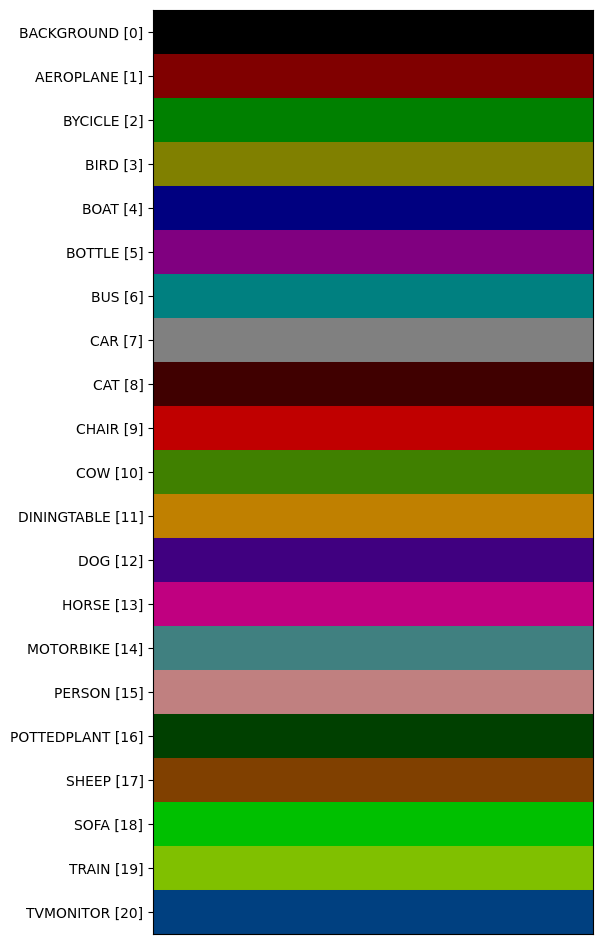

I will give you an image which concatenates horizontally the ground truth and the prediction, which are displayed side-by-side.
The ground truth and the prediction are marked by the corresponding title above them.
In the whole image, the image on the left is the ground truth, and the image on the right is the prediction.


## Instructions

Your task is to find where and how the prediction deviates from the ground truth. Assume the ground truth to be correct. If there are no significant deviations, simply say it.


I provide some examples of correct outputs:
- "Overall, the prediction captured most of the ground truth regions, however, the ground truth SKY region on the top left of the scene has been segmented quite coarsely, some details are missed, while the prediction mask of the ground truth MOUNTAIN region on the center of the scene is incomplete."
- "The prediction mask is quite chaotic, many GRASS regions have been hallucinated all over the scene, while the TREE region has been over-extended towards the top."
- "The ground truth WATER region on the bottom has been segmented with a coarse, irregular shape, especially on the boundary."


Now, I ask you to generate the output based on following input.


Input:

Ground Truth and Prediction.

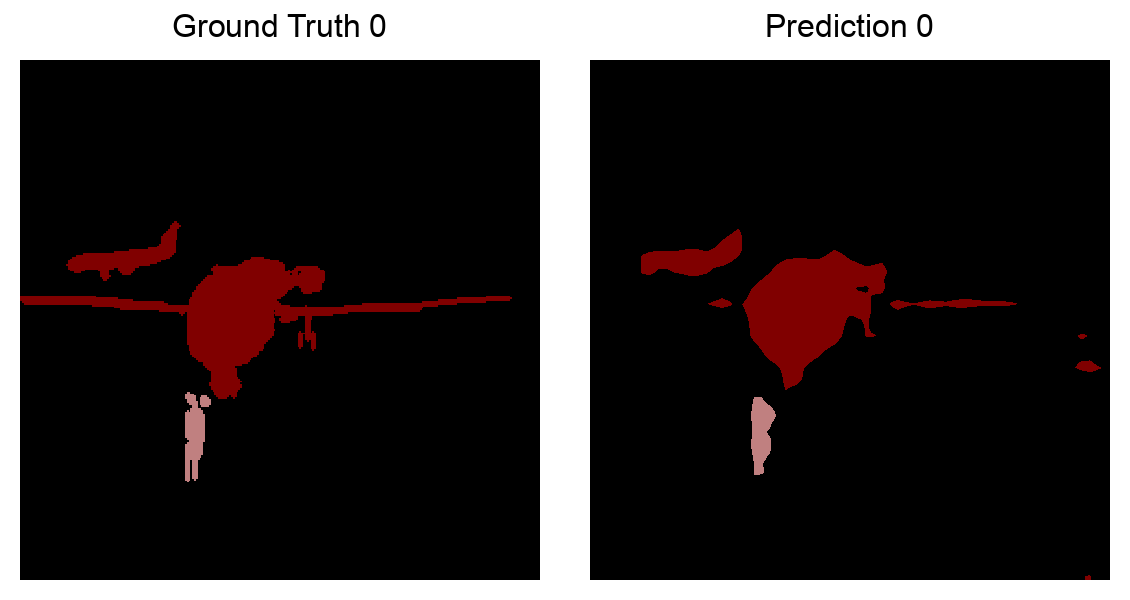

Output:

In [39]:
inference_prompt = promptBuilder.build_inference_prompt(query_idx)
display_prompt(inference_prompt)

In [35]:
answer_pr = vlm.predict_one(inference_prompt)
display(Markdown(answer_pr))

The prediction mask of the BOTTLE region on the left is incomplete, especially on the bottom.


In [22]:
eval_prompt = promptBuilder.build_eval_prompt(query_idx, answer_pr)

In [24]:
eval_pr = vlm.evaluate_one(eval_prompt, parse_to_dict=True)
eval_pr

{'pred': 'incorrect',
 'score': 2,
 'reason': 'The predicted answer only partially captures the issues described in the ground truth. It mentions the BOTTLE region being rough and irregular, with over and under-segmentation, but it misses the key point about the PERSON region being missing and the hallucination of BOTTLE patches in the bottom-left corner. The description of the BOTTLE region inaccuracy is also not precise enough.'}

## Single-Format Batch

In [25]:
input_format = ArrayMasks_InputFormatModule("original")

promptBuilder.load_modules(
    context_module          = ContextModule(variation="default"),
    color_map_module        = Patches_ColorMapModule(variation="default"),
    input_format_module     = input_format,
    task_module             = TaskModule(variation="default"),
    output_format_module    = OutputFormatModule(variation="default"),
    support_set_module      = SupportSetModule(variation="default", sup_set_idxs=(16, 2, 18)),
    query_module            = QueryModule(variation="default"),
    eval_module             = EvalModule(variation="7_incomplet+strict+precision+error_types+spatial_locs")
)

epoch_eval_list = [{"state": promptBuilder.get_state()}]

In [26]:
epoch_idxs = list(range(23))
epoch_idxs = [x for x in epoch_idxs if x not in promptBuilder.sup_set_idxs]
batches_idxs = partition_list(epoch_idxs, 7)
num_batches = len(batches_idxs)
batches_idxs

[[0, 1, 3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14], [15, 17, 19, 20, 21, 22]]

In [ ]:
prompt_desc = input_format.__class__.__name__.removesuffix("_InputFormatModule")
print(f"Evaluating {prompt_desc}.")
for i, batch_idxs in enumerate(batches_idxs):

    batch_eval_list = []

    with ThreadPoolExecutor(max_workers=10) as executor:  # Adjust workers as needed
        future_to_idx = {executor.submit(lambda idx: vlm.predict_and_evaluate_one(promptBuilder, idx, parse_to_dict=True), query_idx): query_idx for query_idx in batch_idxs}
        for future in as_completed(future_to_idx):
            query_idx, eval_ = future.result()
            batch_eval_list.append({"img_idx": query_idx, "content": eval_})

    epoch_eval_list.extend(batch_eval_list)

    print(f"Batch {i+1}/{num_batches} completed.")

    time.sleep(60) if i < num_batches - 1 else None  # Sleep only if not the last batch

Evaluating ArrayMasks.
Batch 1/3 completed.
Batch 2/3 completed.
Batch 3/3 completed.


### Eval. Export

In [ ]:
exp_name = f"test_class_split/non-splitted/{prompt_desc}"

exp_path = get_eval_prs_path(promptBuilder.by_model, "class-splitted", exp_name)

append_many_to_jsonl(exp_path, epoch_eval_list)

## Multi-Format Batch

In [27]:
all_epochs_eval_list = {}
prompt_desc_list = []

In [28]:
inputFormat_list = InputFormatModule.__subclasses__()
num_epochs = len(inputFormat_list)

In [30]:
for e, inputFormat in enumerate(inputFormat_list):

    input_format = inputFormat("original")

    promptBuilder.load_modules(
                context_module          = ContextModule(variation="default"),
                color_map_module        = Patches_ColorMapModule(variation="default"),
                input_format_module     = input_format,
                task_module             = TaskModule(variation="default"),
                output_format_module    = OutputFormatModule(variation="default"),
                support_set_module      = SupportSetModule(variation="default", sup_set_idxs=(16, 2, 18)),
                query_module            = QueryModule(variation="default"),
                eval_module             = EvalModule(variation="7_incomplet+strict+precision+error_types+spatial_locs")
            )

    epoch_eval_list = [{"state": promptBuilder.get_state()}]

    epoch_idxs = list(range(23))
    epoch_idxs = [x for x in epoch_idxs if x not in promptBuilder.sup_set_idxs]
    batches_idxs = partition_list(epoch_idxs, 7)
    num_batches = len(batches_idxs)

    prompt_desc = input_format.__class__.__name__.removesuffix("_InputFormatModule")
    
    print(f"Evaluating {prompt_desc}.")
    for i, batch_idxs in enumerate(batches_idxs):

        batch_eval_list = []

        with ThreadPoolExecutor(max_workers=10) as executor:  # Adjust workers as needed
            future_to_idx = {executor.submit(lambda idx: vlm.predict_and_evaluate_one(promptBuilder, idx, parse_to_dict=True), query_idx): query_idx for query_idx in batch_idxs}
            for future in as_completed(future_to_idx):
                query_idx, eval_ = future.result()
                batch_eval_list.append({"img_idx": query_idx, "content": eval_})

        epoch_eval_list.extend(batch_eval_list)

        print(f"Batch {i+1}/{num_batches} completed.")

        time.sleep(60) if (i < num_batches - 1 or e < num_epochs - 1) else None  # Sleep only if not the last batch
    
    prompt_desc_list.append(prompt_desc)
    all_epochs_eval_list[prompt_desc] = epoch_eval_list

Evaluating ConcatMasks_Sc_Hz.
Batch 1/3 completed.
Batch 2/3 completed.
Batch 3/3 completed.
Evaluating ConcatMasks_Sc_Vr.
Batch 1/3 completed.
Batch 2/3 completed.
Batch 3/3 completed.
Evaluating ConcatMasks_Ovr_Hz.
Batch 1/3 completed.
Batch 2/3 completed.


KeyboardInterrupt: 

In [ ]:
for prompt_desc in prompt_desc_list:

    exp_name = f"test_colormaps/cmap_as_patches/{prompt_desc}"

    exp_path = get_eval_prs_path(promptBuilder.by_model, "non-splitted", exp_name)

    append_many_to_jsonl(exp_path, all_epochs_eval_list[prompt_desc])